# Imports and connect to google drive

In [0]:
import random
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss

from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, BatchNormalization, Conv2D, MaxPooling2D, RNN

from scipy import stats

Using TensorFlow backend.


In [0]:
#Get access to google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


**All users names and activities**

In [0]:
names = ['Shay', 'Ido','Idan','Asaf','Alon','Oren','Hila','Inbar','Alex','Max']
activities = ['drinking', 'eating', 'on_computer', 'on_phone']

data_map = {'training_map': {}, 'validation_map': {}, 'testing_map': {}}

**Creating training validation and testing sets**

In [0]:
#Get csv files from the drive
for name in names:
  for activity in activities:
    data_map['training_map'][f'{name}_{activity}'] = list(map(lambda i: pd.read_csv(
        f'drive/My Drive/Shared folder University/files_project/participates/{name}/{name}_is_{activity}/{i}/{name}_is_{activity}{i}.csv'), range(1,4)))
       
for name in names:
  for activity in activities:
    data_map['validation_map'][f'{name}_{activity}'] = list(map(lambda i: pd.read_csv(
        f'drive/My Drive/Shared folder University/files_project/participates/{name}/{name}_is_{activity}/{i}/{name}_is_{activity}{i}.csv'), range(4,5)))
       
for name in names:
  for activity in activities:
    data_map['testing_map'][f'{name}_{activity}'] = list(map(lambda i: pd.read_csv(
        f'drive/My Drive/Shared folder University/files_project/participates/{name}/{name}_is_{activity}/{i}/{name}_is_{activity}{i}.csv'), range(5,6)))
    
print('training_map containas: {}'.format(len(data_map['training_map']['Shay_drinking'])))
print('validation_map containas: {}'.format(len(data_map['validation_map']['Shay_drinking'])))
print('testing_map containas: {}'.format(len(data_map['testing_map']['Shay_drinking'])))

training_map containas: 3
validation_map containas: 1
testing_map containas: 1


# Preprocessing

**Dealing with NA**

In [0]:
for data_division_map in data_map:
  for name_activity in data_map[data_division_map]:
    for df in data_map[data_division_map][name_activity]:
      number = round(float(df["Heart_Rate"].mean()))
      df.fillna(float(number), inplace=True)

**Shuffling activity data**

In [0]:
def random_activity(l):
    random.shuffle(l)
    return iter(l)

In [0]:
#concat all dataframes
for name in names:
  data_map['training_map'][name] = []
  for i in range(0,3):
    name_activity_index_list = list()
    for activity in random_activity(activities):
      name_activity_index_list.append(data_map['training_map'][f'{name}_{activity}'][i])
    data_map['training_map'][name].append(pd.concat(name_activity_index_list))
  data_map['training_map'][name] = pd.concat(data_map['training_map'][name])
    
for name in names:
  data_map['validation_map'][name] = []
  for i in range(0,1):
    name_activity_index_list = list()
    for activity in random_activity(activities):
      name_activity_index_list.append(data_map['validation_map'][f'{name}_{activity}'][i])
    data_map['validation_map'][name].append(pd.concat(name_activity_index_list))   
  data_map['validation_map'][name] = pd.concat(data_map['validation_map'][name])
    
    
for name in names:
  data_map['testing_map'][name] = []
  for i in range(0,1):
    name_activity_index_list = list()
    for activity in random_activity(activities):
      name_activity_index_list.append(data_map['testing_map'][f'{name}_{activity}'][i])
    data_map['testing_map'][name].append(pd.concat(name_activity_index_list))
  data_map['testing_map'][name] = pd.concat(data_map['testing_map'][name])
    

In [0]:
#concat inter dataframes
for data_division_map in data_map:  
  data_map[data_division_map] = pd.concat([value for key, value in data_map[data_division_map].items() if key in names])

In [0]:
#copy data sets into variables
training_set = data_map['training_map'].copy()
validation_set = data_map['validation_map'].copy()
testing_set = data_map['testing_map'].copy()

del(data_map)

**Data sets size**

In [0]:
print('Training size is: {}'.format(len(training_set)))
print(training_set.isnull().sum())

print('validation size is: {}'.format(len(validation_set)))
print(validation_set.isnull().sum())

print('testing size is: {}'.format(len(testing_set)))
print(testing_set.isnull().sum())

Training size is: 73885
ID            0
Time          0
Acce_X        0
Acce_Y        0
Acce_Z        0
Gyro_X        0
Gyro_Y        0
Gyro_Z        0
Gravity_X     0
Gravity_Y     0
Gravity_Z     0
Roll          0
Pitch         0
Yaw           0
Heart_Rate    0
Activity      0
dtype: int64
validation size is: 24560
ID            0
Time          0
Acce_X        0
Acce_Y        0
Acce_Z        0
Gyro_X        0
Gyro_Y        0
Gyro_Z        0
Gravity_X     0
Gravity_Y     0
Gravity_Z     0
Roll          0
Pitch         0
Yaw           0
Heart_Rate    0
Activity      0
dtype: int64
testing size is: 24547
ID            0
Time          0
Acce_X        0
Acce_Y        0
Acce_Z        0
Gyro_X        0
Gyro_Y        0
Gyro_Z        0
Gravity_X     0
Gravity_Y     0
Gravity_Z     0
Roll          0
Pitch         0
Yaw           0
Heart_Rate    0
Activity      0
dtype: int64


In [0]:
training_set.head()

,ID,Time,Acce_X,Acce_Y,Acce_Z,Gyro_X,Gyro_Y,Gyro_Z,Gravity_X,Gravity_Y,Gravity_Z,Roll,Pitch,Yaw,Heart_Rate,Activity
0,1,16:30:01,0.020015,0.042676,0.002245,-0.292180,0.053346,-0.119537,-0.003338,-0.512356,-0.858766,-0.003886,0.537927,0.001991,78.0,On_Phone
1,1,16:30:01,0.030446,0.051427,0.014540,-0.289519,0.239283,-0.286981,0.018642,-0.477925,-0.878203,0.021224,0.498291,-0.024963,78.0,On_Phone
2,1,16:30:01,0.061171,0.119279,0.026618,-0.260106,0.212153,-0.207484,0.047762,-0.433962,-0.899664,0.053038,0.448885,-0.055818,78.0,On_Phone
3,1,16:30:01,0.035092,0.058898,0.030542,-0.078390,-0.004126,-0.025107,0.074466,-0.387741,-0.918756,0.080874,0.398180,-0.072152,78.0,On_Phone
4,1,16:30:01,-0.008887,0.014132,0.019267,-0.308298,-0.087261,-0.064895,0.090140,-0.359103,-0.928935,0.096733,0.367306,-0.079410,78.0,On_Phone


#Adding features extraction 

In [0]:
training_set_eval = training_set.copy()
validation_set_eval = validation_set.copy()
testing_set_eval = testing_set.copy()

In [0]:
training_set_eval.shape[0]

73885

In [0]:
def create_features(dataFrame):
  #vector features
  dataFrame['length_acce'] = dataFrame.apply(lambda row: math.sqrt(math.pow(row['Acce_X'], 2) + math.pow(row['Acce_Y'],2) + math.pow(row['Acce_Z'],2)) , axis = 1) 

  dataFrame['length_gyro'] = dataFrame.apply(lambda row: math.sqrt(math.pow(row['Gyro_X'], 2) + math.pow(row['Gyro_Y'],2) + math.pow(row['Gyro_Z'],2)) , axis = 1) 

  #dataFrame['length_gravity'] = dataFrame.apply(lambda row: math.sqrt(math.pow(row['Gravity_X'], 2) + math.pow(row['Gravity_Y'],2) + math.pow(row['Gravity_Z'],2)), axis = 1) 

  dataFrame['direction_acce'] = dataFrame.apply(lambda row: math.asin(row['Acce_Y']/row['length_acce']) , axis = 1) 

  dataFrame['direction_gyro'] = dataFrame.apply(lambda row: math.asin(row['Gyro_Y']/row['length_gyro']) , axis = 1) 

  dataFrame['direction_gravity'] = dataFrame.apply(lambda row: math.asin(row['Gravity_Y']) , axis = 1) 
  
  dataFrame['gyro_along_gravity'] = dataFrame.apply(lambda row: (row['Gyro_X']*row['Gravity_X']) + (row['Gyro_Y']*row['Gravity_Y']) + (row['Gyro_Z']*row['Gravity_Z']) , axis = 1) 
  
  #statistical features
  dataFrame['mean_acce'] = dataFrame.apply(lambda row: np.mean([row['Acce_X'], row['Acce_Y'], row['Acce_Z']]), axis = 1) 

  dataFrame['std_acce'] = dataFrame.apply(lambda row: np.std([row['Acce_X'], row['Acce_Y'], row['Acce_Z']]), axis = 1) 
  
  dataFrame['mean_gyro'] = dataFrame.apply(lambda row: np.mean([row['Gyro_X'], row['Gyro_Y'], row['Gyro_Z']]), axis = 1) 

  dataFrame['std_gyro'] = dataFrame.apply(lambda row: np.std([row['Gyro_X'], row['Gyro_Y'], row['Gyro_Z']]), axis = 1) 
  
  dataFrame['mean_gravity'] = dataFrame.apply(lambda row: np.mean([row['Gravity_X'], row['Gravity_Y'], row['Gravity_Z']]), axis = 1) 

  dataFrame['std_gravity'] = dataFrame.apply(lambda row: np.std([row['Gravity_X'], row['Gravity_Y'], row['Gravity_Z']]), axis = 1) 
  
  dataFrame['mean_rpy'] = dataFrame.apply(lambda row: np.mean([row['Roll'], row['Pitch'], row['Yaw']]), axis = 1) 

  dataFrame['std_rpy'] = dataFrame.apply(lambda row: np.std([row['Roll'], row['Pitch'], row['Yaw']]), axis = 1) 
  
  return dataFrame

In [0]:
training_set_eval = create_features(training_set_eval)

validation_set_eval = create_features(validation_set_eval)

testing_set_eval = create_features(testing_set_eval)

In [0]:
training_set_eval.head()

,ID,Time,Acce_X,Acce_Y,Acce_Z,Gyro_X,Gyro_Y,Gyro_Z,Gravity_X,Gravity_Y,Gravity_Z,Roll,Pitch,Yaw,Heart_Rate,Activity,length_acce,length_gyro,direction_acce,direction_gyro,direction_gravity,gyro_along_gravity,mean_acce,std_acce,mean_gyro,std_gyro,mean_gravity,std_gravity,mean_rpy,std_rpy
0,1,16:30:01,0.020015,0.042676,0.002245,-0.292180,0.053346,-0.119537,-0.003338,-0.512356,-0.858766,-0.003886,0.537927,0.001991,78.0,On_Phone,0.047190,0.320162,1.129836,0.167403,-0.537927,0.076297,0.021645,0.016546,-0.119457,0.141060,-0.458153,0.351324,0.178677,0.254039
1,1,16:30:01,0.030446,0.051427,0.014540,-0.289519,0.239283,-0.286981,0.018642,-0.477925,-0.878203,0.021224,0.498291,-0.024963,78.0,On_Phone,0.061507,0.472689,0.990164,0.530791,-0.498291,0.132271,0.032138,0.015106,-0.112406,0.248683,-0.445829,0.366838,0.164851,0.236531
2,1,16:30:01,0.061171,0.119279,0.026618,-0.260106,0.212153,-0.207484,0.047762,-0.433962,-0.899664,0.053038,0.448885,-0.055818,78.0,On_Phone,0.136667,0.394606,1.060853,0.567628,-0.448885,0.082176,0.069023,0.038234,-0.085146,0.211317,-0.428621,0.386803,0.148702,0.216864
3,1,16:30:01,0.035092,0.058898,0.030542,-0.078390,-0.004126,-0.025107,0.074466,-0.387741,-0.918756,0.080874,0.398180,-0.072152,78.0,On_Phone,0.075055,0.082416,0.902268,-0.050079,-0.398180,0.018830,0.041511,0.012435,-0.035874,0.031259,-0.410677,0.405805,0.135634,0.195877
4,1,16:30:01,-0.008887,0.014132,0.019267,-0.308298,-0.087261,-0.064895,0.090140,-0.359103,-0.928935,0.096733,0.367306,-0.079410,78.0,On_Phone,0.025493,0.326915,0.587558,-0.270197,-0.367306,0.063829,0.008171,0.012242,-0.153485,0.109850,-0.399299,0.417005,0.128210,0.183724


In [0]:
#copy data sets into variables
training_set = training_set_eval.copy()
validation_set = validation_set_eval.copy()
testing_set = testing_set_eval.copy()

del(training_set_eval)
del(validation_set_eval)
del(testing_set_eval)

In [0]:
#training_set.to_csv('drive/My Drive/Shared folder University/files_project/training_set.csv',index=False)

#Data visualization

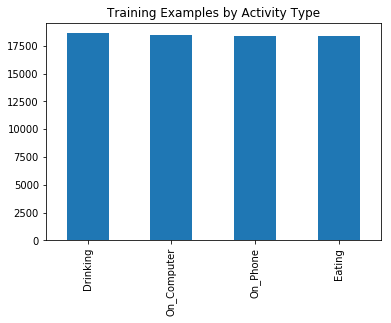

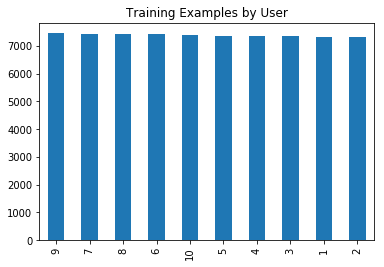

In [0]:
# Show how many training examples exist for each of the six activities
training_set['Activity'].value_counts().plot(kind='bar', title='Training Examples by Activity Type')
plt.show()

# Better understand how the recordings are spread across the different
# users who participated in the study
training_set['ID'].value_counts().plot(kind='bar', title='Training Examples by User')
plt.show()

In [0]:
def plot_activity(activity, data):
    fig, (ax0,ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=7,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['Time'], data['Acce_X'], 'Acc-X-Axis')
    plot_axis(ax1, data['Time'], data['Acce_Y'], 'Acc-Y-Axis')
    plot_axis(ax2, data['Time'], data['Acce_Z'], 'Acc-Z-Axis')
    plot_axis(ax3, data['Time'], data['Gyro_X'], 'Gyro-X-Axis')
    plot_axis(ax4, data['Time'], data['Gyro_Y'], 'Gyro-Y-Axis')
    plot_axis(ax5, data['Time'], data['Gyro_Z'], 'Gyro-Z-Axis')
    plot_axis(ax6, data['Time'], data['Heart_Rate'], 'Heart Rate')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [0]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

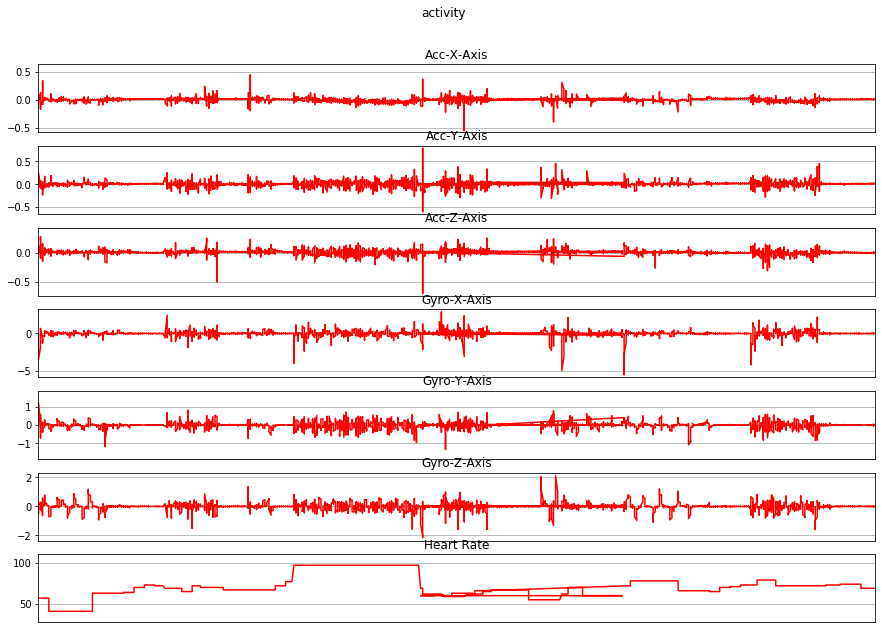

In [0]:
subset = training_set[:6000]
plot_activity('activity', subset)

#Activity Encoder

In [0]:
def create_activity_encoded(data_set, le_set):
    # Define column name of the label vector
    LABEL = 'ActivityEncoded'
    # Add a new column to the existing DataFrame with the encoded values
    data_set[LABEL] = le_set.fit_transform(data_set['Activity'].values.ravel())
    data_set.drop('Activity', axis=1,inplace = True)
    data_set.drop('Time', axis=1,inplace = True)

    '''
    #You need this to get back the real label
    analyze_data[LABEL] = le_set.inverse_transform(analyze_data[LABEL].values.ravel())
    print(analyze_data)
    '''

In [0]:
# Transform the labels from String to Integer via LabelEncoder
le_activity = preprocessing.LabelEncoder()
#le_validation_activity = preprocessing.LabelEncoder()
#le_testing_activity = preprocessing.LabelEncoder()


create_activity_encoded(training_set, le_activity)
create_activity_encoded(validation_set, le_activity)
create_activity_encoded(testing_set, le_activity)

In [0]:
'''
def create_time_encoded(data_set, le_set):
    # Add a new column to the existing DataFrame with the encoded values
    data_set['Time_Stamp'] = le_set.fit_transform(data_set['Time'].values.ravel())
    data_set = data_set.drop('Time', axis=1, inplace = True)

    
    #You need this to get back the real label
    data_set[LABEL] = le_set.inverse_transform(data_set[LABEL].values.ravel())
    print(data_set)
    
'''

"\ndef create_time_encoded(data_set, le_set):\n    # Add a new column to the existing DataFrame with the encoded values\n    data_set['Time_Stamp'] = le_set.fit_transform(data_set['Time'].values.ravel())\n    data_set = data_set.drop('Time', axis=1, inplace = True)\n\n    \n    #You need this to get back the real label\n    data_set[LABEL] = le_set.inverse_transform(data_set[LABEL].values.ravel())\n    print(data_set)\n    \n"

In [0]:
'''
# Transform the time from String to Integer via LabelEncoder
#le_training_time = preprocessing.LabelEncoder()
#le_validation_time = preprocessing.LabelEncoder()
#le_testing_time = preprocessing.LabelEncoder()
le_time = preprocessing.LabelEncoder()

create_time_encoded(training_set,le_time)
create_time_encoded(validation_set,le_time)
create_time_encoded(testing_set,le_time)
'''

'\n# Transform the time from String to Integer via LabelEncoder\n#le_training_time = preprocessing.LabelEncoder()\n#le_validation_time = preprocessing.LabelEncoder()\n#le_testing_time = preprocessing.LabelEncoder()\nle_time = preprocessing.LabelEncoder()\n\ncreate_time_encoded(training_set,le_time)\ncreate_time_encoded(validation_set,le_time)\ncreate_time_encoded(testing_set,le_time)\n'

#Normalize And Standardize Time Series Data



we rescaling the data from original so the vaules are within range of 0 to 1

y  = (x - mean) / std

y = ( x - min) / (max - min)

In [0]:
for column in training_set.columns[1:28]:
    print(column)

Acce_X
Acce_Y
Acce_Z
Gyro_X
Gyro_Y
Gyro_Z
Gravity_X
Gravity_Y
Gravity_Z
Roll
Pitch
Yaw
Heart_Rate
length_acce
length_gyro
direction_acce
direction_gyro
direction_gravity
gyro_along_gravity
mean_acce
std_acce
mean_gyro
std_gyro
mean_gravity
std_gravity
mean_rpy
std_rpy


In [0]:

#go over the colunms in pd and do normalization and standardiztion
for column in training_set.columns[1:28]:
  training_set[column] = (training_set[column] - np.mean(training_set[column]))/(np.std(training_set[column]))
  #training_set[column] = (training_set[column] - min(training_set[column])) / (max(training_set[column]) - min(training_set[column]))
  #3 digits in decimal
  #training_set = round(training_set,3)


In [0]:

#go over the colunms in pd and do normalization and standardiztion
for column in validation_set.columns[1:28]:
  validation_set[column] = (validation_set[column] - np.mean(validation_set[column]))/(np.std(validation_set[column]))
  #validation_set[column] = (validation_set[column] - min(validation_set[column])) / (max(validation_set[column]) - min(validation_set[column]))
  #3 digits in decimal
  #validation_set = round(validation_set,3)


In [0]:

#go over the colunms in pd and do normalization and standardiztion
for column in testing_set.columns[1:28]:
  testing_set[column] = (testing_set[column] - np.mean(testing_set[column]))/(np.std(testing_set[column]))
  #testing_set[column] = (testing_set[column] - min(testing_set[column])) / (max(testing_set[column]) - min(testing_set[column]))
  #3 digits in decimal
  #testing_set = round(testing_set,3)


#Divide into segments

This function will create segments and for each segment will attaced the most significant label 

the size of the segment is SEGMANT_SIZE
the size of which we moving from sgement to segment is STEP_DISTANCE



In [0]:
def create_segments_and_labels(df, segmant_size, step, label_name):
    # sensors as features
    N_FEATURES = 27
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the segmant_size in order to have no overlap between segments)
    # step = segmant_size
    segments = []
    labels = []
    for i in range(0, len(df) - segmant_size, step):
      append_segments = list(map(lambda row: df.iloc[row].values[1:28],range(i, i+segmant_size)))
      segments.append(append_segments)
      label = stats.mode(df[label_name][i: i + segmant_size])[0][0]
      labels.append(label)
    
    np_segments = np.asarray(segments, dtype= np.float32).reshape(-1, segmant_size, N_FEATURES)
    np_labels = np.asarray(labels)
    return np_segments, np_labels

In [0]:
SEGMANT_SIZE = 40
STEP_DISTANCE = 10
LABEL = 'ActivityEncoded'

x_train, y_train = create_segments_and_labels(training_set, SEGMANT_SIZE, STEP_DISTANCE, LABEL)
x_validation, y_validation =  create_segments_and_labels(validation_set, SEGMANT_SIZE, STEP_DISTANCE, LABEL)

#Training and validation data after divided into segments

In [0]:
print(len(training_set))
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

73885
x_train shape:  (7385, 40, 27)
7385 training samples
y_train shape:  (7385,)


In [0]:
print(len(validation_set))
print('x_validation shape: ', x_validation.shape)
print(x_validation.shape[0], 'training samples')
print('y_validation shape: ', y_validation.shape)

24560
x_validation shape:  (2452, 40, 27)
2452 training samples
y_validation shape:  (2452,)


In [0]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le_activity.classes_.size
print(list(le_activity.classes_))

['Drinking', 'Eating', 'On_Computer', 'On_Phone']


In [0]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (7385, 1080)
input_shape: 1080


In [0]:
x_validation = x_validation.reshape(x_validation.shape[0], input_shape)
print('x_validation shape:', x_validation.shape)
print('input_shape_validation:', input_shape)

x_validation shape: (2452, 1080)
input_shape_validation: 1080


In [0]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_validation = x_validation.astype('float32')
y_validation = y_validation.astype('float32')

In [0]:
y_train_hot_encoding = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot_encoding.shape)

New y_train shape:  (7385, 4)


In [0]:
y_validation_hot_encoding = np_utils.to_categorical(y_validation, num_classes)
print('New y_validation shape: ', y_validation_hot_encoding.shape)

New y_validation shape:  (2452, 4)


#Divide test data into segments

In [0]:
x_test, y_test = create_segments_and_labels(testing_set, SEGMANT_SIZE, STEP_DISTANCE, LABEL)

In [0]:
print(len(testing_set))
print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'training samples')
print('y_test shape: ', y_test.shape)

24547
x_test shape:  (2451, 40, 27)
2451 training samples
y_test shape:  (2451,)


In [0]:
x_test = x_test.reshape(x_test.shape[0], input_shape)
print('x_test shape:', x_test.shape)
print('input_shape_test:', input_shape)

x_test shape: (2451, 1080)
input_shape_test: 1080


In [0]:
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

In [0]:
#y_test_hot_encoding = np_utils.to_categorical(y_test, num_classes)
#print('New y_test shape: ', y_test_hot_encoding.shape)

#ML approch

In [0]:
# spot check ml algorithms on engineered-features from the har dataset
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Random Forest Classifier

In [0]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
print("Random Forest Classifier model accuracy on test set is : {0:.3f}%".format(rf_model.score(x_test, y_test)*100))
rf_model_y_test_pred = rf_model.predict(x_test)
print(classification_report(y_test, rf_model_y_test_pred))

Random Forest Classifier model accuracy on test set is : 70.012%
              precision    recall  f1-score   support

         0.0       0.64      0.62      0.63       617
         1.0       0.77      0.81      0.79       612
         2.0       0.78      0.75      0.76       612
         3.0       0.61      0.62      0.62       610

    accuracy                           0.70      2451
   macro avg       0.70      0.70      0.70      2451
weighted avg       0.70      0.70      0.70      2451



Text(0.5, 1.0, 'Random Forest Classifier model classification results on validation set')

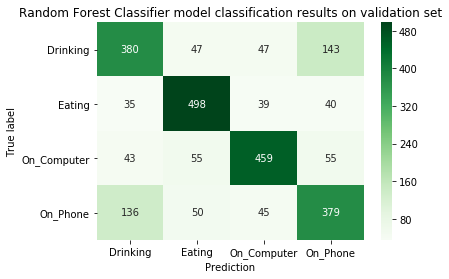

In [0]:
sns.heatmap(confusion_matrix(y_test, rf_model_y_test_pred),cmap='Greens',annot=True, fmt='d',
           xticklabels=list(le_activity.classes_), yticklabels=list(le_activity.classes_))
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('Random Forest Classifier model classification results on validation set')

#XGBoost Classifier

In [0]:
# fit model no training data
xgboost_model = XGBClassifier()
xgboost_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
print("XGBoost Classifier model accuracy on test set is : {0:.3f}%".format(xgboost_model.score(x_test, y_test)*100))
xgboost_model_y_test_pred = xgboost_model.predict(x_test)
print(classification_report(y_test, xgboost_model_y_test_pred))

XGBoost Classifier model accuracy on test set is : 69.319%
              precision    recall  f1-score   support

         0.0       0.59      0.55      0.57       617
         1.0       0.78      0.79      0.79       612
         2.0       0.83      0.79      0.81       612
         3.0       0.58      0.64      0.61       610

    accuracy                           0.69      2451
   macro avg       0.70      0.69      0.69      2451
weighted avg       0.70      0.69      0.69      2451



Text(0.5, 1.0, 'XGBoost Classifier model classification results on validation set')

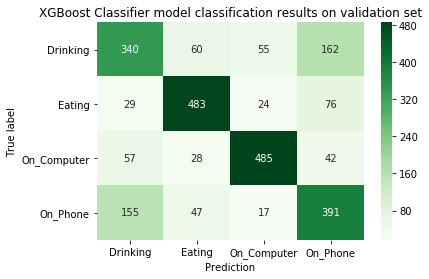

In [0]:
sns.heatmap(confusion_matrix(y_test, xgboost_model_y_test_pred),cmap='Greens',annot=True, fmt='d',
           xticklabels=list(le_activity.classes_), yticklabels=list(le_activity.classes_))
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('XGBoost Classifier model classification results on validation set')

#DL approch

#LSTM model

In [0]:
# fit and evaluate a model
def evaluate_lstm_model(trainX, trainy, valX, valy):
  verbose, epochs, batch_size = 1, 200, 128
  n_features, n_outputs = 27, 4
  model = Sequential()  
  model.add(Reshape((SEGMANT_SIZE, n_features), input_shape=(input_shape,)))
  model.add(BatchNormalization())
  model.add(LSTM(10, recurrent_dropout=0.15, activation='relu'))  
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation='softmax'))
  print(model.summary())
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit network
  history = model.fit(trainX, trainy, validation_data=(valX, valy), epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model, history

In [0]:
lstm_model, lstm_history = evaluate_lstm_model(x_train, y_train_hot_encoding, x_validation, y_validation_hot_encoding)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 40, 27)            0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 40, 27)            108       
_________________________________________________________________
lstm_4 (LSTM)                (None, 10)                1520      
_________________________________________________________________
batch_normalization_10 (Batc (None, 10)                40        
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
batch_normalization_11 (Batc (None, 10)                40        
__________

In [0]:
  '''
# Save the weights
lstm_model.save_weights('drive/My Drive/files_project/model_files/model_weights.h5')

# Save the model architecture
with open('drive/My Drive/files_project/model_files/model_architecture.json', 'w') as f:
    f.write(lstm_model.to_json())
'''

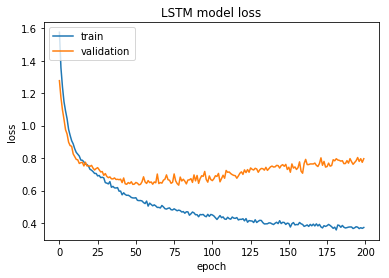

In [0]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

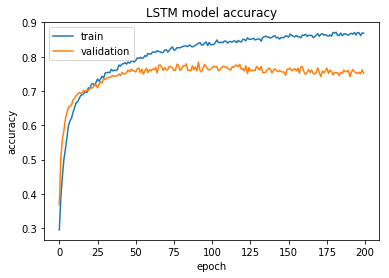

In [0]:
plt.plot(lstm_history.history['acc'])
plt.plot(lstm_history.history['val_acc'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
lstm_preds_train = lstm_model.predict(x_train[:len(y_train)])
lstm_pred_cat_train = np.argmax(lstm_preds_train,axis=1)

lstm_preds_val = lstm_model.predict(x_validation[:len(y_validation)])
lstm_pred_cat_val = np.argmax(lstm_preds_val,axis=1)

lstm_preds_test = lstm_model.predict(x_test[:len(y_test)])
lstm_pred_cat_test = np.argmax(lstm_preds_test,axis=1)

In [0]:
len(y_test)
len(lstm_preds_test)

2451

LSTM model accuracy on traning set is: 91.41503046716318%


Text(0.5, 1.0, 'LSTM model classification results on traning set')

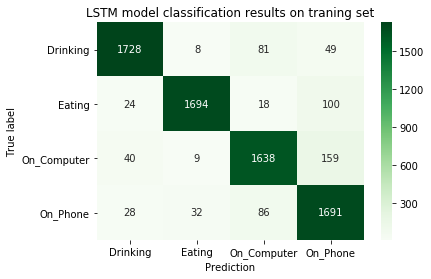

In [0]:
print('LSTM model accuracy on traning set is: {}%'.format(accuracy_score(y_train[:len(lstm_pred_cat_train)],lstm_pred_cat_train)*100))
sns.heatmap(confusion_matrix(y_train[:len(lstm_pred_cat_train)],lstm_pred_cat_train),cmap='Greens',annot=True, fmt='d',
           xticklabels=list(le_activity.classes_), yticklabels=list(le_activity.classes_))

plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('LSTM model classification results on traning set')

LSTM model accuracy on validation set is: 75.163132137031%


Text(0.5, 1.0, 'LSTM model classification results on validation set')

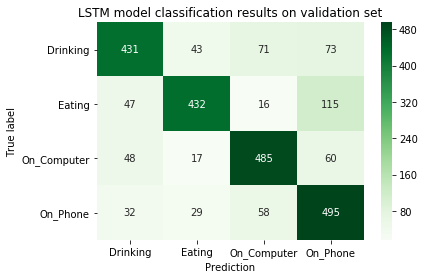

In [0]:
print('LSTM model accuracy on validation set is: {}%'.format(accuracy_score(y_validation[:len(lstm_pred_cat_val)],lstm_pred_cat_val)*100))
sns.heatmap(confusion_matrix(y_validation[:len(lstm_pred_cat_val)],lstm_pred_cat_val),cmap='Greens',annot=True, fmt='d',
           xticklabels=list(le_activity.classes_), yticklabels=list(le_activity.classes_))

plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('LSTM model classification results on validation set')

LSTM model accuracy on test set is: 73.96980824153407%


Text(0.5, 1.0, 'LSTM model classification results on test set')

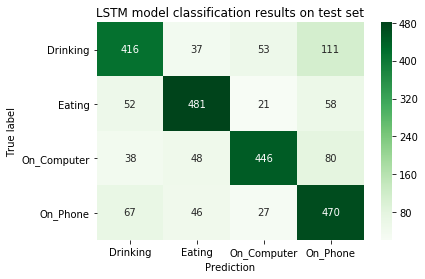

In [0]:
print('LSTM model accuracy on test set is: {}%'.format(accuracy_score(y_test[:len(lstm_pred_cat_test)],lstm_pred_cat_test)*100))
sns.heatmap(confusion_matrix(y_test[:len(lstm_pred_cat_test)],lstm_pred_cat_test),cmap='Greens',annot=True, fmt='d',
            xticklabels=list(le_activity.classes_), yticklabels=list(le_activity.classes_))

plt.xlabel('Prediction') 
plt.ylabel('True label')
plt.title('LSTM model classification results on test set')

In [0]:
asdadasdasda

#Final result metric

#Convert Into CoreML

In [0]:
'''
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('drive/My Drive/Shared folder University/files_project/model_files/model_architecture.json', 'r') as f:
    lstm_model = model_from_json(f.read())

# Load weights into the new model
lstm_model.load_weights('model_weights.h5')
'''

In [0]:
!pip install coremltools

In [0]:
import coremltools

coreml_model = coremltools.converters.keras.convert(ann_model, input_names=['acceleration'], output_names=['output'], class_labels=list(le_activity.classes_))

print(coreml_model)
coreml_model.author = 'ido sakazi'
coreml_model.license = 'N/A'
coreml_model.short_description = 'Activity based recognition based on dataset'
coreml_model.output_description['output'] = 'Probability of each activity'
coreml_model.output_description['classLabel'] = 'Labels of activity'

#coreml_model.save('drive/My Drive/Shared folder University/files_project/model_files/HARClassifier.mlmodel')
#coreml_model.save('HARClassifier.mlmodel')

In [0]:
#coreml_model.save('ANNHARClassifier.mlmodel')